In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rockhound as rh
import cmocean
from scipy.ndimage.filters import gaussian_filter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import colors as mcolors
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Polygon
import os
from datetime import datetime, timedelta
from scipy.io import loadmat
import datetime as dt

def datenum2datetime(matlab_datenum):
    python_datetime = dt.timedelta(days=matlab_datenum -366)+dt.datetime(1,1,1)
    python_datetime = np.datetime64(python_datetime)
    return python_datetime

user = 'XXXXXXXXX'

In [2]:
# fetch etopo 1 arc-minute elevation data set
# use 'ice' to include ice sheets
grid = rh.fetch_etopo1(version="ice")

In [3]:
''' Overview plot for subpolar North Atlantic (SPNA) region 
          with regional study areas outlined '''

### Prepare data and plotting 
spna = grid.sel(longitude=slice(-70,60),latitude=slice(50,85))

# plot parameters
c_lat = 67.5
c_lon = -5
zoom = dict({'name': 'zoomed_out',
                 'extent': [-58,48,37.5,85.5],
                  'ticks': [5,10]})
proj = ccrs.LambertConformal(central_longitude=c_lon)
transform = ccrs.PlateCarree()

# if using coastlines
coastline = cfeature.NaturalEarthFeature(
            category='physical',
            name='land',
            scale='10m')
coast_kw = dict(facecolor='#CCCCCC',
                edgecolor='#333333', alpha=1)

# for sea ice filled contours - colormap settings
sif_cmap_bw = plt.cm.Blues.reversed()
sif_cmap_bw.set_under('w', alpha=0)
sif_kw = dict(extend='both', levels=np.arange(0.2, 1.2, 0.2),
              cmap=sif_cmap_bw)
cmap = sif_cmap_bw

### Polygon coordinate set up
# polygons may have any number of vertices
# in format: [[x1,y1],[x2,y2],[x3,y3]... ...[x1,y1]]
# note, must close loop ending with original point!

Irm_coords = [[-38,60],[-25,60],[-25,65.25],[-38,65.25],[-38,60]] 
Ice_coords = [[-22,66.5],[-8,66.5],[-8,70.5],[-22,70.5],[-22,66.5]]
Gre_coords = [[-17,71],[-2,71],[-2,77],[-17,77],[-17,71]]
Sva_coords = [[-1,75],[15,75],[8,82],[-1,82],[-1,75]]
Bar_coords = [[34,71],[50,71],[50,79],[34,79],[34,71]]
Nor_coords = [[1,64],[7,64],[17,71],[1,71],[1,64]]
Lab_coords = [[-54,54],[-48,59],[-59,66],[-64,61],[-54,54]]

polys = {'Irminger':{'verts':Irm_coords,
                    'rectangular':True,
                    'color':'red',
                    'label':'Irminger\nSea'},
         'Iceland':{'verts':Ice_coords,
                    'rectangular':True,
                    'color':'orange',
                    'label':'Iceland\nSea'},
         'Greenland':{'verts':Gre_coords,
                    'rectangular':True,
                    'color':'green',
                    'label':'Greenland\nSea'},
         'Svalbard':{'verts':Sva_coords,
                    'rectangular':False,
                    'color':'blue',
                    'label':'Fram\nStrait'},
         'Barents':{'verts':Bar_coords,
                    'rectangular':True,
                    'color':'purple',
                    'label':'Barents\nSea'},
         'Norwegian':{'verts':Nor_coords,
                    'rectangular':False,
                    'color':'magenta',
                    'label':'Norwegian\nSea'},
         'Labrador':{'verts':Lab_coords,
                    'rectangular':False,
                    'color':'cyan',
                    'label':'Labrador\nSea'}
        }

latlonlabels = {'N60':{'lon':-71.0,
                      'lat':60,
                      'label':r'$60^{\circ}$N'},
                'N70':{'lon':-71.0,
                      'lat':70,
                      'label':r'$70^{\circ}$N'},
                'N80':{'lon':-71.0,
                      'lat':80,
                      'label':r'$80^{\circ}$N'},
                'W30':{'lon':-29.0,
                      'lat':49,
                      'label':r'$30^{\circ}$W'},
                'W60':{'lon':-60.0,
                      'lat':49,
                      'label':r'$60^{\circ}$W'},
                'E30':{'lon':32.0,
                      'lat':47.5,
                      'label':r'$30^{\circ}$E'},
               }

def plot_NA_boundary(ax):
    ax.plot(np.linspace(-70,60,100),
            np.linspace(50,50,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(60,60,100),
            np.linspace(50,85,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(-70,60,100),
            np.linspace(85,85,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(-70,-70,100),
            np.linspace(50,85,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    return ax

def find_poly_midpoint(poly):
    x_list = []
    y_list = []
    for i in polys[poly]['verts']:
        x_list.append(i[0])
        y_list.append(i[1])
    xmin = min(x_list)
    xmax = max(x_list)
    xmid = xmin + ((xmax-xmin)/2)
    ymin = min(y_list)
    ymax = max(y_list)
    ymid = ymin + ((ymax-ymin)/2)
    return xmid,ymid

# Open ERA5 winters dataset (prepped in ERA5_winters.pynb)
f = '/local/{}/Datasets/ERA5_NAtlantic_winter_means_1950_2020_V2.nc'.format(user)
ds_era_winters_1950_2020 = xr.open_mfdataset(f, chunks={'year':1})
ds_era_winters_1950_2020 = ds_era_winters_1950_2020.rename({'latitude':'lat',
                                'longitude':'lon'})
ds_era_winters_1950_2020 = ds_era_winters_1950_2020.sortby('lat')
ds_era_winters_1950_2020_NA = ds_era_winters_1950_2020.sel(lon=slice(-70,60),
                                                            lat=slice(50,85))
ds_era_winters_1950_2020.close()

/local/scratch/jbj13rpu@uea.ac.uk/anaconda3/envs/IGP_env/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


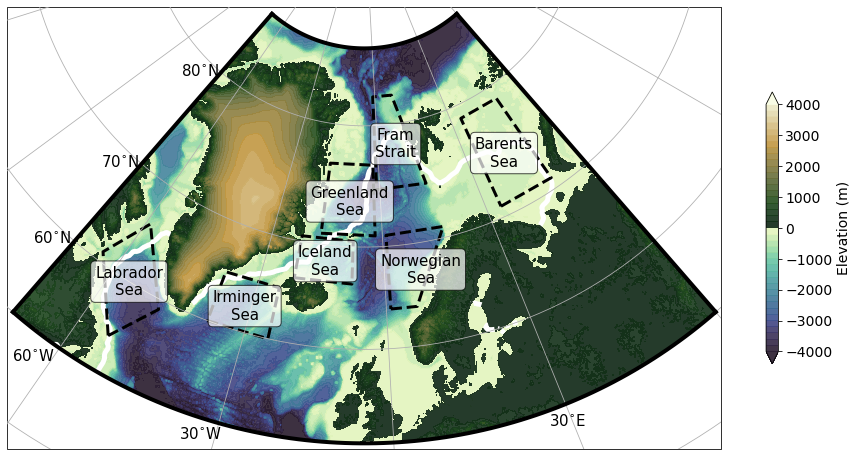

In [4]:
### plot SPNA overview
fig = plt.figure(figsize=(16,10))
ax = plt.subplot(projection=proj)
ax.set_extent(zoom['extent'])
# ax.add_feature(coastline,**coast_kw,zorder=10)
plt.rcParams.update({'font.size': 14})
plot_NA_boundary(ax)

# etopo (smoothed using gaussian filter)
lon = gaussian_filter(spna.longitude,2)
lat = gaussian_filter(spna.latitude,2)
z = gaussian_filter(spna.ice,2)

levels_all = np.arange(-4000,4200,200)

topo_land = ax.contourf(lon,lat,z,
                   levels_all,cmap=cmocean.cm.topo,
                     transform=transform,
                  vmin=-4000, vmax=4200,extend='both',alpha=0.9) #

ticks = np.arange(-4000,5000,1000)
cb = plt.colorbar(topo_land,ticks=ticks,shrink=0.5)
cb.set_label('Elevation (m)',fontsize=14)

# Plot siconc
siconc = ds_era_winters_1950_2020_NA.siconc.mean(dim='year')
levels_sst = np.arange(-2,13,1)
levels_siconc = [0.25] #[0.15,0.50,0.8,1]

# if using filled contours
# siconc_plot = ax.contourf(siconc.lon,siconc.lat,siconc.load()/100,
#                        levels=levels_siconc,
#                        cmap=cmap,transform=transform,
#                       zorder=5,alpha=0.5)

# white line to indicate selected contour (25%)
sinconc_con = plt.contour(siconc.lon,
                     siconc.lat,
                     siconc.load(),
                          colors='w',linewidths=5,
                         levels=levels_siconc,
                          transform=transform,zorder=10,alpha=1)

# plot study area outlines and labels
for region in polys:
    xs, ys = zip(*polys[region]['verts'])
    ax.plot(xs,ys,color='k',linestyle='dashed',
            linewidth=3,
           transform=transform,zorder=11)
gl = ax.gridlines(crs=transform, draw_labels=False,zorder=20)

for poly in polys:
    xmid,ymid = find_poly_midpoint(poly)
    plt.text(xmid,ymid,polys[poly]['label'],
            size=15,ha='center',va='center',
            transform=transform,zorder=20,
            bbox=dict(boxstyle='round',
                     ec='k',
                     fc='w',
                     alpha=0.7))

for label in latlonlabels:
    plt.text(latlonlabels[label]['lon'],
            latlonlabels[label]['lat'],
            latlonlabels[label]['label'],
             size=15,ha='right',va='center',
            transform=transform,
            zorder=30)

sdir = '/local/{}/Plots/GC31_evaluation/overview/'.format(user)
sname = 'overview_map_V2.jpg'
fig.savefig(sdir+sname,dpi=300)

In [5]:
'''IGP CAO1 COUPLED OBSERVATIONS PAPER
            OVERVIEW FIGURE
            
- Set extent for region of interest (x1,x2,y1,y2)

- Set start and end datetimes for period of interest
for AMSR2 mean period, sondes, ship track, argo 

'''

### Settings

# region
extent = [-30,-10,66,72]
x1,x2,y1,y2 = extent[0],extent[1],extent[2],extent[3]

# time period
#### To Do if I want to automate below selections!

### Pre-processing   

# grab etopo
grid = rh.fetch_etopo1(version="ice")
etopo_CAO1 = grid.sel(longitude=slice(x1,x2),
                      latitude=slice(y1,y2))

# open ship met data set
f = '/local/{}/Datasets/IGP_Alliance_Surface_Met_QC3_10min.nc'.format(user)
ds_ship = xr.open_dataset(f)
ds_ship_10min = ds_ship.copy()
ds_ship_10min_CAO1 = ds_ship_10min.sel(time=slice('2018-02-28T00:00:00',
                                            '2018-03-07T23:50:00'))

# open and select radiosondes
f = '/local/{}/Datasets/IGP_radiosondes/Alliance_radiosondes_all.nc'.format(user)
ds_sondes_all = xr.open_dataset(f)
ds_sondes = ds_sondes_all.sel(time=slice('2018-02-27T23:00:00',
                 '2018-03-08T00:00:00'))

# argo data open and convert .mat to xr dataset
f = '/local/{}/Datasets/ARGOtrack_EOMlocation.mat'.format(user)
file = loadmat(f)

argo_lon = file['ARGO_lon'][0]
argo_lat = file['ARGO_lat'][0]
argo_time = file['ARGO_time'][0]

argo_time_np64 = []
for i in range(len(argo_time)):
    time_np64 = datenum2datetime(argo_time[i])
    argo_time_np64.append(time_np64)

da_argo_lon = xr.DataArray(argo_lon, coords={'time':argo_time_np64},
                          dims=['time'])
da_argo_lat = xr.DataArray(argo_lat, coords={'time':argo_time_np64},
                          dims=['time'])
    
    
ds_argo = xr.Dataset({'lon':da_argo_lon,
                      'lat':da_argo_lat},
                     coords={'time':argo_time_np64})
ds_argo_CAO1 = ds_argo.sel(time=slice('2018-03-01T00:00:00',
                 '2018-03-14T00:00:00'))
                           
# open and average amsr2 for period
amsr2_large = xr.open_dataset('/local/{}/Datasets/amsr2_regridded/AMSR2_6km_during_IGP.nc'.format(user))
CAO1_daterange_amsr2 = pd.date_range('2018-02-28T12:00:00','2018-03-07T12:00:00',freq='1D')
ds_amsr2_CAO1 = amsr2_large.sel(time=CAO1_daterange_amsr2)
ds_amsr2_CAO1_mean = ds_amsr2_CAO1.mean(dim='time')
ds_amsr2_CAO1_mean = ds_amsr2_CAO1_mean.sel(lon=slice(x1,x2),
                                            lat=slice(y1,y2))

# plotting settings            
def plot_IGP_CAO1_boundary(ax):
    # plot domain edge borders
    ax.plot(np.linspace(x1,x2,100),
            np.linspace(y1,y1,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(x2,x2,100),
            np.linspace(y1,y2,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(x1,x2,100),
            np.linspace(y2,y2,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    ax.plot(np.linspace(x1,x1,100),
            np.linspace(y1,y2,100),'k',
            linewidth=4,
           transform=transform,zorder=30)
    return ax

def plot_manual_gridlines(ax):
    lons = np.arange(x1,x2+1,5)
    lats = np.arange(y1,y2+1,2)

    for lat in lats:
        ax.plot(np.linspace(x1,x2,100),
                 np.linspace(lat,lat,100),
                 transform=transform,
                color='grey',linewidth=1,zorder=20)
    for lon in lons:
        ax.plot(np.linspace(lon,lon,100),
                 np.linspace(y1,y2,100),
                 transform=transform,
                color='grey',linewidth=1,zorder=20)
    return ax

def plot_latlonlabels(ax):
    lon_label_y = 65.8
    lat_label_x = -31.0
    latlonlabels2 = {'N66':{'lon':lat_label_x,
                          'lat':66,
                          'label':r'$66^{\circ}$N'},
                     'N68':{'lon':lat_label_x,
                          'lat':68,
                          'label':r'$68^{\circ}$N'},
                    'N70':{'lon':lat_label_x,
                          'lat':70,
                          'label':r'$70^{\circ}$N'},
                     'N72':{'lon':lat_label_x,
                          'lat':72,
                          'label':r'$72^{\circ}$N'},
                     'W30':{'lon':-30.0,
                          'lat':lon_label_y,
                          'label':r'$30^{\circ}$W'},
                    'W25':{'lon':-25.0,
                          'lat':lon_label_y,
                          'label':r'$25^{\circ}$W'},
                    'W20':{'lon':-20.0,
                          'lat':lon_label_y,
                          'label':r'$20^{\circ}$W'},
                    'W15':{'lon':-15.0,
                          'lat':lon_label_y,
                          'label':r'$15^{\circ}$W'},
                     'W10':{'lon':-10.0,
                          'lat':lon_label_y,
                          'label':r'$10^{\circ}$W'},
                   }

    for label in latlonlabels2:
        ax.text(latlonlabels2[label]['lon'],
                latlonlabels2[label]['lat'],
                latlonlabels2[label]['label'],
                 size=15,ha='center',va='center',
                transform=transform,
                zorder=30)
    return ax

c_lat = 67.5
c_lon = -20
zoom = dict({'name': 'zoomed_out',
                 'extent': [x1,x2,y1-1,y2+1],
                  'ticks': [5,10]})
proj = ccrs.NorthPolarStereo(central_longitude=c_lon,
                                 true_scale_latitude=c_lat)
transform = ccrs.PlateCarree()

/local/scratch/jbj13rpu@uea.ac.uk/anaconda3/envs/IGP_env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


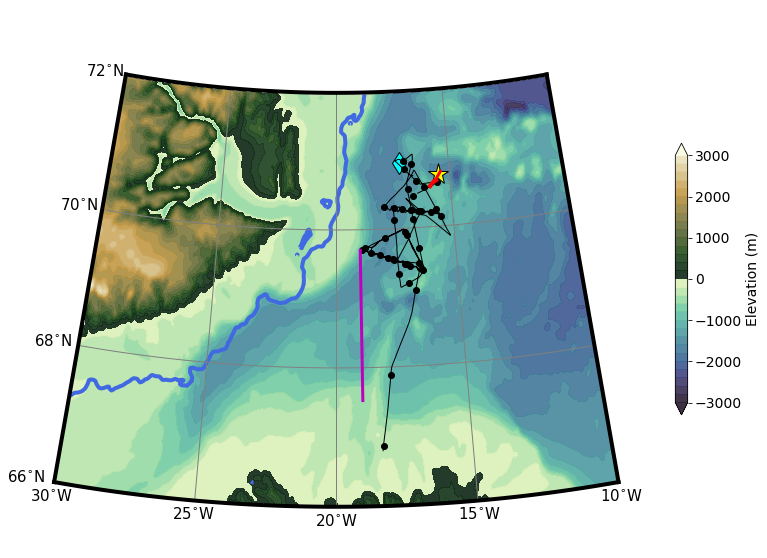

In [6]:
### plot figure

# create fig and ax
fig = plt.figure(figsize=(16,10))
ax = plt.subplot(projection=proj)
ax.set_extent(zoom['extent'])

# figure presentation
plt.rcParams.update({'font.size': 14})
plot_IGP_CAO1_boundary(ax)
plot_manual_gridlines(ax)
plot_latlonlabels(ax)
ax.axis('off')

# plot etopo elevation
lon = gaussian_filter(etopo_CAO1.longitude,2)
lat = gaussian_filter(etopo_CAO1.latitude,2)
z = gaussian_filter(etopo_CAO1.ice,2)
levels_all = np.arange(-3000,3200,200)

etopo = ax.contourf(lon,lat,z,
                   levels_all,cmap=cmocean.cm.topo,
                     transform=transform,
                  vmin=-3000, vmax=3200,extend='both',alpha=0.9)

ticks = np.arange(-3000,4000,1000)
cb = plt.colorbar(etopo,ticks=ticks,shrink=0.5)
cb.set_label('Elevation (m)',fontsize=14)

# plot AMSR2 siconc
levels_siconc = [0.5] #[0.15,0.50,0.8,1]
amsr2_plot = ax.contour(ds_amsr2_CAO1_mean.lon,
            ds_amsr2_CAO1_mean.lat,
            ds_amsr2_CAO1_mean.siconc/100,
            levels=levels_siconc,
            colors='royalblue',linewidths=4,
            transform=transform)

### plot observations
# Met buoy
ax.plot(-15.5,70.75,marker='*',markersize=22,
        markerfacecolor='yellow',markeredgecolor='k',
        linestyle='None',
       transform=transform, label='Met Buoy',
       zorder=25)
# Ship track
ax.plot(ds_ship_10min_CAO1.longitude_nmea,
        ds_ship_10min_CAO1.latitude_nmea,
        c='black', label='Ship Track',
        linewidth=1,
        transform=transform,zorder=26)
# Sonde locations
ax.plot(ds_sondes.longitude,ds_sondes.latitude,
       'ok',transform=transform,zorder=27)
# Aircraft XS
ax.plot([-19,-19],[67.525,69.7],
       c='m',linewidth=3,
       transform=transform,zorder=29)
# ARGO float
ax.plot(ds_argo_CAO1.lon,ds_argo_CAO1.lat,
       color='red',linewidth=3,
       transform=transform,zorder=28)
# Glider
ax.plot([-17.20],[70.95],
       marker='d',markerfacecolor='cyan',
        markeredgecolor='k',markersize=16,
       transform=transform,zorder=25)

### Save
sdir = '/local/{}/Plots/new_for_CAO_lifecycle/'.format(user)
sname = 'CAO1_overview_map_V2.jpg'
fig.savefig(sdir+sname,dpi=300,bbox_inches='tight')